# Install & Import

In [1]:
!pip install torchviz
!pip install torchsummary
!pip install wandb
!pip install -U albumentations

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import shutil
import matplotlib.pyplot as plt
from PIL import Image
import random
import tqdm


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [4]:
import torchvision.transforms as transforms
from torchvision.transforms import Resize, Compose, PILToTensor, InterpolationMode, ToPILImage
from torchvision import models

In [5]:
from torchsummary import summary
from torchviz import make_dot

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [6]:
import wandb
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.nn import init


# Data Preprocessing

In [7]:
def set_seed(seed=42):
    """Set random seed for reproducibility across numpy, random, and torch.

    Args:
        seed (int): Seed value to set for reproduction. Defaults to 42.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(903)

In [8]:
class Classification_dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['COVID', 'Non_COVID', 'Normal']
        self.data = []
        self.class_to_id = {clazz: i for i, clazz in enumerate(self.classes)}
        for clazz in self.classes:
            class_dir = os.path.join(root_dir, clazz)
            class_id = self.class_to_id[clazz]
            for img in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img)
                self.data.append((img_path, class_id))
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, id):
        img_path, label = self.data[id]
        
        try:
            img = cv2.imread(img_path)
            if img is None:
                raise ValueError()
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      
        except Exception as e:
            return None, None

        if self.transform:
            transform = self.transform(image=img)
            img = transform['image']
            
        return img, label

In [9]:
classification_root_dir = 'results/classification'
classification_ds = Classification_dataset(classification_root_dir)

In [10]:
def visualize_classification(dataset, n=5):
    random_sample_ids = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(16, 8))

    for i, idx in enumerate(random_sample_ids):
        image, label = dataset[idx]
        image = image.permute(1, 2, 0).cpu().numpy()   
        height, width, _ = image.shape
        class_name = dataset.dataset.classes[label]
        
        plt.subplot(1, n, i + 1)
        plt.imshow(image)
        plt.title(f'Class: {class_name}\nSize: ({height}, {width})')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [11]:
train_size = int(0.8 * len(classification_ds))
val_size = int(0.1 * len(classification_ds))
test_size = len(classification_ds) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(classification_ds, [train_size, val_size, test_size])

In [12]:
# img_size = 256

# train_transform = A.Compose([
#     A.LongestMaxSize(max_size=img_size),
#     A.GaussianBlur(blur_limit=(3, 7), p=0.5),
#     A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8)),
#     ToTensorV2(),
# ])

# val_transform = A.Compose([
#     A.LongestMaxSize(max_size=img_size),
#     ToTensorV2(),
# ])

In [13]:
img_size = 256

train_transform = A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.GaussianBlur(blur_limit=(3, 7), p=0.5),
            A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8)),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

val_transform = A.Compose([
    A.LongestMaxSize(max_size=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [14]:
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

In [15]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

In [16]:
len(train_dataset), len(val_dataset), len(test_dataset)

(35914, 4489, 4490)

In [17]:
print(train_dataset[0][0].shape)

torch.Size([3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5179956].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5354247].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.448279].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.465708].


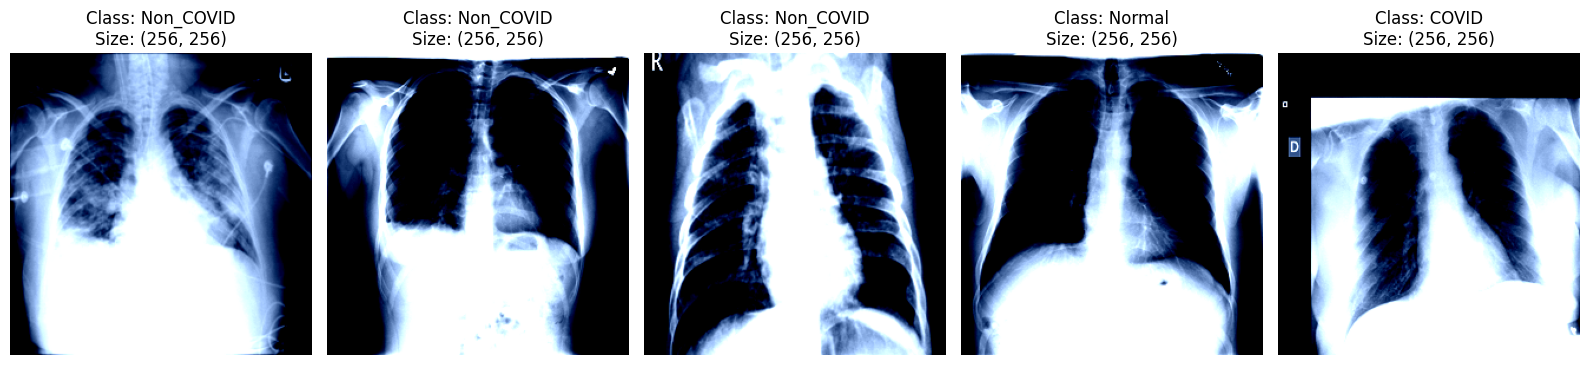

In [18]:
visualize_classification(train_dataset, n=5)

# Building model

In [19]:
img_size = 256
num_classes = 3 

In [20]:
# Loading VGG16 as a base model, and remove the fully connected layers
base_model = models.vgg16(pretrained=True)
base_features = nn.Sequential(*list(base_model.features))

/home/carbure/PycharmProjects/HS_Wat_Blockchain/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/carbure/PycharmProjects/HS_Wat_Blockchain/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
# Unfreeze all layers
for param in base_model.parameters():
    param.requires_grad = True

In [22]:
# Build the model
model = nn.Sequential(
    base_features,
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes),
    #nn.Softmax(dim=1)
)

In [23]:
# Summary the model
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

summary(model, input_size=(3, img_size, img_size), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [24]:
# Visualize the model
from torchviz import make_dot

x = torch.rand(1, 3, img_size, img_size).to("cuda")

y = model(x)
make_dot(y, params=dict(model.named_parameters())).render("vgg16-image-classifier", format="png")


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [41]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = '/kaggle/working/vgg16-image-classifier.png'
img = mpimg.imread(image_path)

plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.axis('off')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'results/vgg16-image-classifier.png'

# Training

In [ ]:
wandb.login(key="cf90b2e5896b9cfbf0b23241c4a55fe500e5b58f")

In [25]:
PROJECT = "DeepLearningProject"
RESUME = "allow"
NUM_EPOCHS = 30
LEARNING_RATE = 0.000001
CHECKPOINT_PATH = 'results/vgg16_final_watermarked.pth'

In [26]:
# Initialize optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
wandb.init(

    project=PROJECT,

    resume=RESUME,

    config={

        "learning_rate": LEARNING_RATE,

        "epochs": NUM_EPOCHS,

        "batch_size": 32

    },

)

wandb.watch(model)

In [27]:
# Initialize scheduler
scheduler = ReduceLROnPlateau(optimizer, patience=3, factor=0.5, verbose=True)

/home/carbure/PycharmProjects/HS_Wat_Blockchain/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [29]:
epochs = NUM_EPOCHS
best_val_accuracy = 0
best_val_loss = None

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [30]:
for epoch in range(epochs):
    print(f'####################################  EPOCH {epoch+1}/{epochs}  #####################################')

    # Train phase
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device).float(), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate the accuracy in each batch
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        total_loss += loss.item()

        if batch_idx % 100 == 99 or batch_idx == 0:
            print(f'Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}, Accuracy: {correct/total:.4f}')

    # Save loss and accuracy for training phase
    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f'Epoch {epoch+1} completed. Average Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    # Validation phase
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device)
      
            outputs = model(inputs)
            
            loss = loss_fn(outputs, labels)
            val_loss += loss.item() 
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Step the scheduler
    scheduler.step(val_loss)

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_val_loss = val_loss
        torch.save(model.state_dict(), CHECKPOINT_PATH)
        print(f'New best model saved with accuracy {best_val_accuracy:.4f} to {CHECKPOINT_PATH}')

    # Log results to WandB
    # wandb.log({
    #     "epoch": epoch,
    #     "train_loss": epoch_loss,
    #     "train_accuracy": epoch_accuracy,
    #     "val_loss": val_loss,
    #     "val_accuracy": val_accuracy,
    # })
         
print(f'Best model with loss {best_val_loss:.4f} and accuracy {best_val_accuracy:.4f}')
# wandb.finish()   

####################################  EPOCH 1/30  #####################################
Batch 1/1122, Loss: 1.1240, Accuracy: 0.2188
Batch 100/1122, Loss: 1.1120, Accuracy: 0.3003
Batch 200/1122, Loss: 1.0759, Accuracy: 0.3436
Batch 300/1122, Loss: 1.0544, Accuracy: 0.3657
Batch 400/1122, Loss: 1.0313, Accuracy: 0.3783
Batch 500/1122, Loss: 1.0909, Accuracy: 0.3926
Batch 600/1122, Loss: 1.0972, Accuracy: 0.4043
Batch 700/1122, Loss: 0.9600, Accuracy: 0.4162
Batch 800/1122, Loss: 0.7631, Accuracy: 0.4327
Batch 900/1122, Loss: 0.7825, Accuracy: 0.4485
Batch 1000/1122, Loss: 0.8129, Accuracy: 0.4661
Batch 1100/1122, Loss: 0.6975, Accuracy: 0.4831
Epoch 1 completed. Average Loss: 0.9847, Accuracy: 0.4865
Validation Loss: 0.6371, Validation Accuracy: 0.7654
New best model saved with accuracy 0.7654 to results/vgg16_final_watermarked.pth
####################################  EPOCH 2/30  #####################################
Batch 1/1122, Loss: 1.0149, Accuracy: 0.7188
Batch 100/1122, Loss: 0

In [31]:
print("Validation Loss and Accuracy for each epoch:")
for epoch in range(1, len(val_losses) + 1):
    loss = val_losses[epoch - 1]
    accuracy = val_accuracies[epoch - 1]
    print(f'Epoch {epoch}: Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

Validation Loss and Accuracy for each epoch:
Epoch 1: Loss: 0.6371, Accuracy: 0.7654
Epoch 2: Loss: 0.4256, Accuracy: 0.8384
Epoch 3: Loss: 0.3369, Accuracy: 0.8734
Epoch 4: Loss: 0.2980, Accuracy: 0.8891
Epoch 5: Loss: 0.2626, Accuracy: 0.9002
Epoch 6: Loss: 0.2389, Accuracy: 0.9105
Epoch 7: Loss: 0.2275, Accuracy: 0.9136
Epoch 8: Loss: 0.2094, Accuracy: 0.9214
Epoch 9: Loss: 0.1980, Accuracy: 0.9263
Epoch 10: Loss: 0.1907, Accuracy: 0.9272
Epoch 11: Loss: 0.1841, Accuracy: 0.9301
Epoch 12: Loss: 0.1832, Accuracy: 0.9299
Epoch 13: Loss: 0.1735, Accuracy: 0.9353
Epoch 14: Loss: 0.1690, Accuracy: 0.9371
Epoch 15: Loss: 0.1663, Accuracy: 0.9406
Epoch 16: Loss: 0.1616, Accuracy: 0.9395
Epoch 17: Loss: 0.1640, Accuracy: 0.9375
Epoch 18: Loss: 0.1657, Accuracy: 0.9397
Epoch 19: Loss: 0.1524, Accuracy: 0.9433
Epoch 20: Loss: 0.1538, Accuracy: 0.9422
Epoch 21: Loss: 0.1486, Accuracy: 0.9460
Epoch 22: Loss: 0.1491, Accuracy: 0.9435
Epoch 23: Loss: 0.1462, Accuracy: 0.9453
Epoch 24: Loss: 0.147

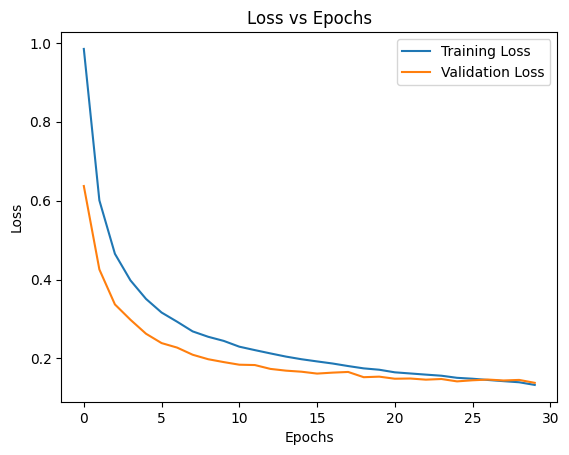

In [45]:
# Plot loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')
plt.savefig('results/loss_epochs_watermarked.pdf', format="pdf")

torch.save(train_losses, "results/train_losses_wat.pth")
torch.save(val_losses, "results/train_losses_wat.pth")

plt.show()

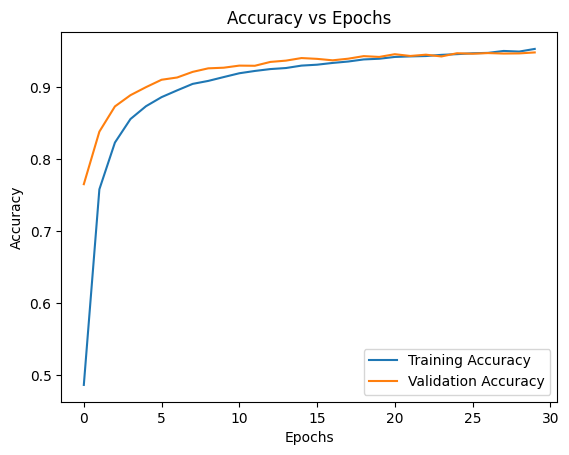

In [46]:
# Plot accuracy
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

torch.save(train_accuracies, "results/train_accuracies_wat.pth")
torch.save(val_accuracies, "results/val_accuracies_wat.pth")

plt.savefig('results/acc_epochs_watermarked.pdf', format="pdf")
plt.show()

# Testing watermarked model

In [34]:
img_size = 256
num_classes = 3

# Loading VGG16 as a base model, and remove the fully connected layers
base_model = models.vgg16(pretrained=False)
base_features = nn.Sequential(*list(base_model.features))

# Adding layers
best_model = nn.Sequential(
    base_features,
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes),
    nn.Softmax(dim=1)
)
CHECKPOINT_PATH = CHECKPOINT_PATH
# Load weights
best_model.load_state_dict(torch.load(CHECKPOINT_PATH))
best_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)

# Evaluate
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device)
        #inputs = inputs.float()
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(outputs.cpu().numpy())

# Calculate metrics
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

/home/carbure/PycharmProjects/HS_Wat_Blockchain/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/carbure/PycharmProjects/HS_Wat_Blockchain/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_733791/3691729221.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release

Accuracy: 0.9500
Precision: 0.9509
Recall: 0.9500
F1 Score: 0.9503


In [35]:
print("\nClassification Report:\n", classification_report(all_labels, all_preds))


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1573
           1       0.96      0.93      0.95      1839
           2       0.88      0.92      0.90      1068

    accuracy                           0.95      4480
   macro avg       0.94      0.95      0.95      4480
weighted avg       0.95      0.95      0.95      4480



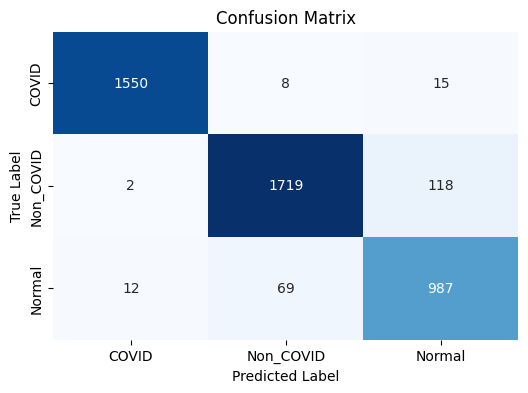

In [47]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
           xticklabels=val_dataset.dataset.classes, yticklabels=val_dataset.dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig('results/confusion_Matrix_watermarked.pdf', format="pdf")
plt.show()

In [ ]:
# Now read the watermark informations : 
# 


In [48]:
train_accuracies_orig = torch.load("results_check_orig/train_accuracies.pth")
train_losses_orig = torch.load("results_check_orig/train_losses.pth")

val_accuracies_orig = torch.load("results_check_orig/val_accuracies.pth")
val_losses_orig = torch.load("results_check_orig/val_losses.pth")


/tmp/ipykernel_733791/3264480978.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_accuracies_orig = torch.load("results_check_orig/train_accuracies.pth")
/tmp/ipyke

In [52]:
print(len(val_losses_orig))
print(len((val_losses)))

30
30


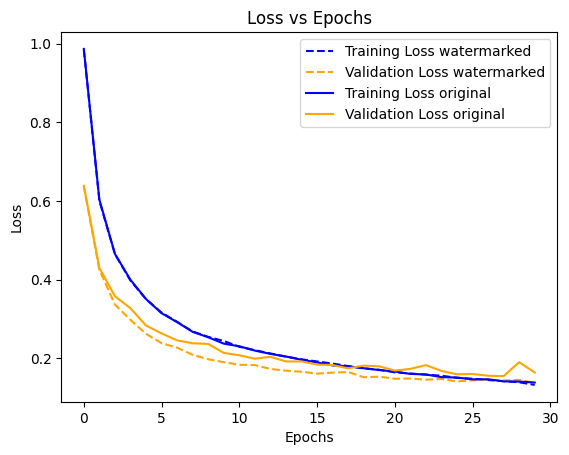

In [53]:
# Use the same blue color for training losses and same orange color for validation losses
plt.plot(train_losses, label='Training Loss watermarked', linestyle='--', color='blue')  
plt.plot(val_losses, label='Validation Loss watermarked', linestyle='--', color='orange')  
plt.plot(train_losses_orig, label='Training Loss original', linestyle='-', color='blue')  
plt.plot(val_losses_orig, label='Validation Loss original', linestyle='-', color='orange')  

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')
plt.savefig('results/loss_epochs_mix.pdf', format="pdf")
plt.show()

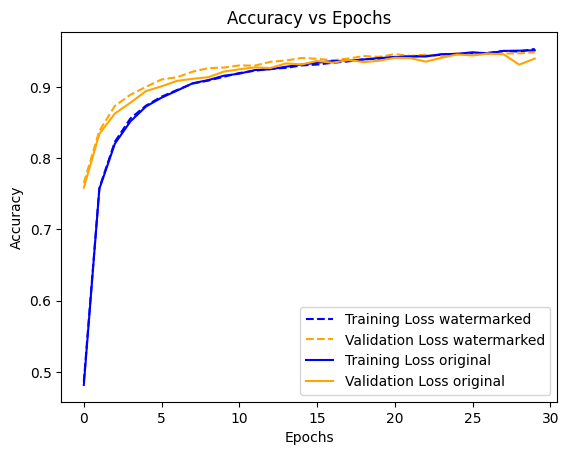

In [54]:
# Use the same blue color for training losses and same orange color for validation losses
plt.plot(train_accuracies, label='Training Loss watermarked', linestyle='--', color='blue')  
plt.plot(val_accuracies, label='Validation Loss watermarked', linestyle='--', color='orange')  
plt.plot(train_accuracies_orig, label='Training Loss original', linestyle='-', color='blue')  
plt.plot(val_accuracies_orig, label='Validation Loss original', linestyle='-', color='orange')  

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

plt.savefig('results/acc_epochs_mix.pdf', format="pdf")
plt.show()

# Build the original lowders


In [55]:
classification_root_dir_orig = 'database/classification'
classification_ds_orig = Classification_dataset(classification_root_dir_orig)

In [56]:
train_size_orig = int(0.8 * len(classification_ds_orig))
val_size_orig = int(0.1 * len(classification_ds_orig))
test_size_orig = len(classification_ds_orig) - train_size_orig - val_size_orig
train_dataset_orig, val_dataset_orig, test_dataset_orig = random_split(classification_ds_orig, [train_size_orig, val_size_orig, test_size_orig])

In [57]:
train_dataset_orig.dataset.transform = train_transform
val_dataset_orig.dataset.transform = val_transform

train_loader_orig = DataLoader(train_dataset_orig, batch_size=32, shuffle=True, drop_last=True)
val_loader_orig = DataLoader(val_dataset_orig, batch_size=32, shuffle=False, drop_last=True)

test_loader_orig = DataLoader(test_dataset_orig, batch_size=32, shuffle=False, drop_last=True)
len(train_dataset), len(val_dataset), len(test_dataset)

(35914, 4489, 4490)

# Testing original model

In [61]:
img_size = 256
num_classes = 3

# Loading VGG16 as a base model, and remove the fully connected layers
base_model = models.vgg16(pretrained=False)
base_features = nn.Sequential(*list(base_model.features))

# Adding layers
best_model = nn.Sequential(
    base_features,
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes),
    nn.Softmax(dim=1)
)
CHECKPOINT_PATH = "results_check_orig/vgg16_final.pth"
CHECKPOINT_PATH_WAT = "results/vgg16_final_watermarked.pth"
# Load weights
best_model.load_state_dict(torch.load(CHECKPOINT_PATH_WAT))
best_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)

# Evaluate
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader_orig:
        inputs, labels = inputs.to(device).float(), labels.to(device)
        #inputs = inputs.float()
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(outputs.cpu().numpy())

# Calculate metrics
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

/tmp/ipykernel_733791/2717850218.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(CHECKPOINT_PATH_WAT))


Accuracy: 0.9571
Precision: 0.9579
Recall: 0.9571
F1 Score: 0.9574
